# MNIST Classification using Apache MXNet
---
## Introduction
Apache MXNet is an open-source deep learning framework used to train and deploy deep neural networks. It is scalable, allowing for fast model training, and supports multiple languages (C++, Python, R, Scala, etc.). MXNet has two high-level interfaces: the `Gluon` API for imperative programming and the `Module` API for symbolic programming. We will focus on using the `Gluon` API for this tutorial. An imperative model works better for real-time/stochastic models because the graph is able to be modified over time. 

MXNet is being used by major cloud services companies, such as Amazon AWS and Microsoft Azure as their deep learning framework of choice.

MXNet is supported by Intel, Dato, Baidu, Microsoft, Wolfram Research, and research institutions such as Carnegie Mellon, MIT,University of Washington, and Hong Kong University of Science and Technology.

The following table compares the top deep learning frameworks based on a series of metrics.

![deep learning comparisons](./assets/comparisons.png)

In the image below, data is preprocessed in an imperative language at the top and the network is declared symbolically at the bottom.

![programming paradigms](./assets/paradigms.jpeg)

---

## Installation for MacOS
### MXNet installation
If installing for a different operating system, refer to the official [installation instructions](https://mxnet.apache.org/install/index.html).

**Step 1** Install prerequisites - Homebrew, python development tools.

```
# Install Homebrew
$ /usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
$ export PATH=/usr/local/bin:/usr/local/sbin:$PATH
# Install python development tools - python2.7, pip, python-setuptools
$ brew install python
```

**Step 2** Install MXNet with OpenBLAS acceleration.

Installing MXNet with pip requires a latest version of `pip`. Install the latest version of `pip` by issuing the following command.
```
$ pip install --upgrade pip
$ pip install --upgrade setuptools
```

```
$ pip install mxnet
```

**Step 3** Install Graphviz. (Optional, needed for graph visualization using mxnet.viz package).
```
$ brew install graphviz
$ pip install graphviz
```
### Validate MXNet installation
Start the python terminal.
```
$ python
```
Run a short MXNet python program to create a 2X3 matrix of ones, multiply each element in the matrix by 2 followed by adding 1. We expect the output to be a 2X3 matrix with all elements being 3.
```
>>> import mxnet as mx
>>> a = mx.nd.ones((2, 3))
>>> b = a * 2 + 1
>>> b.asnumpy()
array([[ 3.,  3.,  3.],
       [ 3.,  3.,  3.]], dtype=float32)
```

### matplotlib installation 
We will be using matplotlib to make visualize our data and learned model for linear regression.

**Step 1** `pip install matplotlib`

---

## Part I: Linear Regression with Apache MXNet
A deep learning library isn't needed to do the fairly simple task of linear regression with polynomial features. However, working through this problem will introduce us to the mechanics of MXNet and give us a crash course on how to use the library. 

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

/Users/jasonbak/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


### `NDArrays`
`NDArrays` are a core data structure to MXNet. They execute code lazily, allowing for parallelization. By design, `NDArray` is similar to NumPy's multi-dimensional array. However, `NDArray` has a few advantages. 

1) `NDArray` support asynchronous computation on CPU, GPU, and distributed cloud architectures.

2) They provide support for automatic differentiation (one function call to perform gradient descent)

Many `NumPy` methods have `NDArray` counterparts with almost identical syntax. For example NumPy has `np.zeros()`, `np.dot()`, and `np.random.normal()` while nd has `nd.zeros()`, `nd.dot()`, and `nd.random_normal()`.

### Set the context
Every `NDArray` has a context, either a CPU or one of various available GPUs. By assigning arrays to contexts intelligently, we can optimize the performance of our code. For example, when training neural networks on a server with a GPU, it is preferred for the model's parameters to live on the GPU to minimize the time spent transferring data between devices. 

MXNet can run identically on CPUs and GPUs. Even though my laptop doesn't have an Nvidia GPU, I can still write and run MXNet code that can easily be factored to work on GPU-enabled systems.

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### Generate data with the help of `NDArray`
We'll generate dummy data, `x`, to model by sampling from a uniform distribution. The labels will be generated according to the true labeling function $y = 5x^4 + 3.5x + 3 + \epsilon$, for $\epsilon \sim \mathscr{N}(0,\sigma^2)$

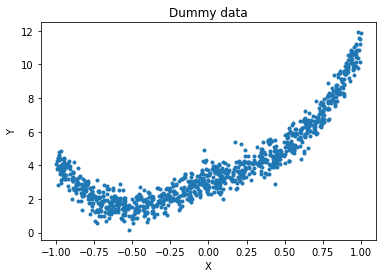

In [3]:
# Help get train data in the final form
num_inputs = 1
num_examples = 1000
raw_data = nd.random.uniform(low=-1, high=1, shape=(num_examples,
    num_inputs))

# Set up training data
num_features = 2
raw_train_data = nd.ones((num_examples, num_features), ctx=data_ctx)
raw_train_data[:,0] = (raw_data[:,0]**4)
raw_train_data[:,1] = (raw_data[:,0])
train_noise = 0.5*nd.random.normal(shape=(num_examples,), ctx=data_ctx)
def actualFunc(raw_train_data):
    return 5*raw_train_data[:, 0] + 3.5*raw_train_data[:, 1] + 3
train_label = actualFunc(raw_train_data) + train_noise

plt.plot(raw_data.asnumpy(), train_label.asnumpy(), '.')
plt.title('Dummy data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Our goal is to learn a labeling function that best fits the data points. We can use this function to predict the Y values for new data points. Our labeling function will be in the form of:

$$\hat{y} = Xw + b$$ 

where `X` is the data, `w` is the desired weight vector, `b` is the bias term, and $\hat{y}$ is the predictions corresponding to `X`, 

### `Data Iterators`
`Data Iterators` allow us to construct data batches from the overall training data. We can iterate over the data batches during training. Specifically, we will work the the `DataLoader` and `ArrayDataset` classes.

`ArrayDataset` allows us to combines multiple dataset-like objects, like `NDArrays`. To load `raw_train_data` and `train_label` into the `ArrayDataset` object. These two inputs must have the same number of rows.

In [4]:
print('Length of raw_train_data:', raw_train_data.shape[0])
print('Length of train_label:', train_label.shape[0])

train_dataset = gluon.data.ArrayDataset(raw_train_data, train_label)

Length of raw_train_data: 1000
Length of train_label: 1000


We will pass in the `ArrayDataset` object to a `DataLoader` constructor. The `DataLoader` object will be an iterator used to return mini-batches of data and their corresponding labels during training.

`batch_size` specifies how many examples we want to show to the model for each iteration of training. `shuffle` tells the iterator to randomize the order in which examples are shown to the model.

In [5]:
# Create data iterators
batch_size = 32
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for (data, label) in train_data:
    print(data, label)
    break


[[  1.38864204e-01   6.10446453e-01]
 [  2.30136067e-01   6.92621827e-01]
 [  1.70113470e-08  -1.14204884e-02]
 [  6.27444208e-01   8.90007734e-01]
 [  8.35205615e-01   9.55978990e-01]
 [  1.06057383e-01   5.70670247e-01]
 [  1.54881284e-01  -6.27335310e-01]
 [  3.88014922e-03  -2.49581337e-01]
 [  1.62175432e-01  -6.34594440e-01]
 [  1.04707740e-01  -5.68845987e-01]
 [  1.22156106e-02  -3.32451880e-01]
 [  3.00860584e-01   7.40612984e-01]
 [  1.65105890e-02   3.58459949e-01]
 [  1.88307259e-02   3.70439053e-01]
 [  3.65949672e-05   7.77777433e-02]
 [  2.88586250e-07  -2.31776237e-02]
 [  9.00550839e-03  -3.08054149e-01]
 [  8.84324163e-02  -5.45321822e-01]
 [  4.16762754e-02  -4.51827049e-01]
 [  7.69363251e-05  -9.36554074e-02]
 [  3.86915579e-02   4.43510652e-01]
 [  1.94181830e-01   6.63822770e-01]
 [  9.12568625e-03  -3.09076786e-01]
 [  2.67692715e-01  -7.19298482e-01]
 [  7.59214610e-02  -5.24917603e-01]
 [  7.28887366e-03  -2.92189837e-01]
 [  1.55344801e-02   3.53040218e-01]


### Define the model
`gluon` allows us to compose a network from predefined layers. For a linear model, the appropriate layer to use is `Dense` because every node in the input is connected to every node in the subsequent layer.

`gluon` can infer the shape of our parameters. In other words, we can specify the output dimension and leave the input dimension ambiguous for now.

In [6]:
# Output dimension=1 and explicit input dimension=2
#net = gluon.nn.Dense(1, in_units=2)

# Initialize the model and define the model's architecture
net = gluon.nn.Dense(1)

### Initialize parameters
We can grab all of the networks parameters in a `gluon.parameter.ParameterDict` object by running the following code.

In [7]:
net.collect_params()

dense0_ (
  Parameter dense0_weight (shape=(1, 0), dtype=<class 'numpy.float32'>)
  Parameter dense0_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)

We initialize parameters by calling the `initialize()` method on a `ParameterDict`. We will pass in an initializer (a probability distribution used to generate values) and a context for where the parameters should reside.

Though we call `initialize()`, parameter initialization is deferred until needed, i.e., on the first forward pass.

In [8]:
# Initialize model's parameters from a Normal distribution with std dev of 0.05
net.collect_params().initialize(mx.init.Normal(sigma=0.05), ctx=model_ctx)

### Define loss
We need to use a function that helps the model understand what a better set of values for our predicted weights are. Loss functions take (output, label) pairs and compute a scalar that represents the performance of our current model. We’re going to use a squared error loss function.

In [9]:
# Define loss function (how well the model is able to correctly predict)
square_loss = gluon.loss.L2Loss()

### Optimization algorithm
We need to optimize the learned parameters of our model to minimize the loss function, i.e., optimize performance of our model. 

A common optimizer to use is stochastic gradient descent (SGD). At each step, we estimate the gradient of the loss function with respect to our learned weights, using one batch randomly drawn from our dataset. Then, we update our parameters a small amount in the direction that reduces the loss. The size of the step is determined by the learning rate.

We can instantiate an optimizer of type `gluon.Trainer` with a `gluon.parameter.ParameterDict` to help us perform SGD.

In [10]:
# Use SGD training algorithm
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.1})

### Execute training loop
For some number of `epochs`, we grab a batch of inputs to use to update our model parameters and completely pass over the dataset `(train_data)` to calculate our loss for our updated model parameters.

`autograd` records a computation graph to calculate gradients. Building the computation graph requires a non-trivial amount of work, so MXNet only builds the graph when instructed to. We can tell MXNet to start generating the graph inside a `with autograd.record()` block. We'll continually report metrics to see how our model if performing at the end of every epoch.

In [11]:
epochs = 10
for e in range(epochs):
    cumulative_loss = 0
    for data, label in train_data:
        with autograd.record(): # Start recording gradients
            # Generate predictions on the forward pass
            output = net(data)
            # Calcualte loss
            loss = square_loss(output, label)
            # Perform backprop
            loss.backward()
        # Update parameters
        trainer.step(batch_size)
        cumulative_loss += nd.mean(loss).asscalar()
    # After each epoch, report loss on training
    print("Epoch %s, loss: %s" % (e+1, cumulative_loss / num_examples))

Epoch 1, loss: 0.0896242829263
Epoch 2, loss: 0.0180958600789
Epoch 3, loss: 0.0118076176941
Epoch 4, loss: 0.00871423504129
Epoch 5, loss: 0.00722783204913
Epoch 6, loss: 0.00620109848678
Epoch 7, loss: 0.00551332327724
Epoch 8, loss: 0.00513597278297
Epoch 9, loss: 0.00474290190637
Epoch 10, loss: 0.00464173685759


### Verifying our model's performance
We've finished training and can grab the weights our model has learned.

In [12]:
# Retrieve learned model's parameters
params = net.collect_params()
for param in params.values():
    print(param.name,param.data())

dense0_weight 
[[ 4.51768827  3.45234132]]
<NDArray 1x2 @cpu(0)>
dense0_bias 
[ 3.15197945]
<NDArray 1 @cpu(0)>


We can plot a best-fit curve on top of our data to see how well we modeled the data.

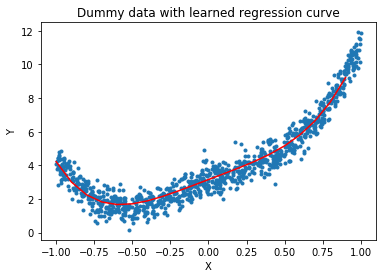

In [13]:
b2 = 4.51768827
b1 = 3.45234132
b0 = 3.15197945

plt.plot(raw_data.asnumpy(), train_label.asnumpy(), '.')
x_values = nd.arange(-1,stop=1,step=0.1)
train_pred = b2*x_values**4 + b1*x_values + b0
plt.plot(x_values.asnumpy(), train_pred.asnumpy(), color='r')
plt.title('Dummy data with learned regression curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Now we know how to do linear regression in MXNet. Next, we'll look at how these basic MXNet concepts translate to a more advanced task - classification using neural networks.

---

## Part II: Handwritten digit classification using CNN
In our second task, we will build a deep neural network called a multilayer perceptron (MLP) to classify hand-written digits. We will use the MNIST dataset, which is a collection of 28x28 greyscale images of handwritten digits and their correct labels.

The model we will build is purposely similar to the one we built for linear regression to show the power of abstraction using a deep learning library like Apache MXNet affords us. The main difference is the way we define our model. We will use `gluon.nn.Sequential` because it provides a way to rapidly add layers to our neural network. 

First, we'll want to set the contexts for our data and models.

In [14]:
# Set the context
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### The MNIST dataset and defining a `Data Iterator`
Before we define the model, we need to fetch the MNIST dataset. Luckily MXNet has a function that grabs this exact dataset.

The data comes in the form a 28x28 array, where each element is a pixel value. We will reshape the data into a flat 1-D structure of 784 (28*28) pixel values to enable easy processing and convert the arrays to the MXNet native NDArray object class.

We can use the `DataLoader` and `ArrayDataset` as a `Data Iterators` again to quickly and efficiently stream data into a training algorithm.

In [15]:
# Import the dataset using a native MXNet utils function
raw_data = mx.test_utils.get_mnist()

# We have 28*28=784 pixels; flatten all the pixels
# Set up the training data and reshape the pictures
raw_train_data_np = raw_data['train_data'].reshape((-1, 784))
raw_train_data = mx.nd.array(raw_train_data_np, ctx=data_ctx)
train_label_np = mx.nd.array(raw_data['train_label'])
train_label = mx.nd.array(train_label_np, ctx=data_ctx)
num_examples = raw_train_data.shape[0]

# Set up the test data and reshape the pictures
test_data_np = raw_data['test_data'].reshape((-1, 784))
test_data = mx.nd.array(test_data_np)
test_label_np = raw_data['test_label']
test_label = mx.nd.array(test_label_np, ctx=data_ctx)

train_dataset = gluon.data.ArrayDataset(raw_train_data, train_label)
batch_size = 32
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Define a sequential model
An MLP is a sequential model, which mean it consist of a chain of fully connected layers. A fully connected layer is one in which each neuron (node) in the layer is connected to every neuron in the subsequent layer. 

We can define the sequential mode with `gluon.nn.Sequential`. We can compose multiple layers together into a neural network by using `net.add(...)`

In an MLP, outputs of most  fully connected layers are fed into an activation function, which gives the network the ability to classify inputs that are not linearly separable. We have a design choice for which activation functions we use. For this example, we'll use the common sigmoid and rectifier linear unit (ReLU) functions.

We will build a MLP with the following architecture:

- Input layer: an array of 28*28=784 pixel values
- 1st layer: 64 neurons activated by the sigmoid function
- 2nd layer: 64 neurons activated by the ReLU function
- Output layer: 10 neurons (for our 10 categories; one for each of 10 possible digits).

In [16]:
# Initialize the model
net = gluon.nn.Sequential()
# Define the model's architecture
num_hidden = 64
with net.name_scope():
    # 1st layer
    net.add(gluon.nn.Dense(num_hidden, activation="sigmoid"))
    # 2nd layer
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    # Output layer
    net.add(gluon.nn.Dense(10))

### Parameter initialization
We'll use the `initialize()` method on a `ParameterDict` as we did in linear regression.

In [17]:
# Initialize model's parameters from a Normal distribution with std dev of 0.05
net.collect_params().initialize(mx.init.Normal(sigma=0.05), ctx=model_ctx)

### Loss function
We'll use the softmax cross entropy loss function to measure how well our model is performing.

In [18]:
# Define loss function (how well the model is able to correctly predict)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Optimizer
We'll use SGD as our optimizer again.

In [19]:
# Use SGD training algorithm
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.1})

### Training loop
We defined our network, input, and loss functions at a high-level. So we can actually use the same exact code from the linear regression training loop for our MLP training loop.

In [20]:
epochs = 10
for e in range(epochs):
    cumulative_loss = 0
    for data,label in train_data:
        with autograd.record(): # Start recording gradients
            # Generate predictions on the the forward pass
            output = net(data)
            # Calculate loss
            loss = softmax_cross_entropy(output, label)
            # Perform backprop
            loss.backward()
        # Update parameters
        trainer.step(batch_size)
        cumulative_loss += nd.mean(loss).asscalar()
    # After each epoch, report loss on training
    print("Epoch %s, loss: %s" % (e+1, cumulative_loss / num_examples))

Epoch 1, loss: 0.0239177005344
Epoch 2, loss: 0.00883275447488
Epoch 3, loss: 0.00642959712379
Epoch 4, loss: 0.00504233574094
Epoch 5, loss: 0.00418490802585
Epoch 6, loss: 0.003593439972
Epoch 7, loss: 0.00316399939778
Epoch 8, loss: 0.00283676895007
Epoch 9, loss: 0.00251428466857
Epoch 10, loss: 0.00227561734641


### Verify model

We'll report the final accuracy on test data because it tells us the accuracy rate on data not seen during training. If training data accuracy is high while test data accuracy is low, our model may have over-fit to the training data and we would need to decrease the complexity of our model.

In [21]:
# Calculate and report accuracy of predictions from our learned model
acc = mx.metric.Accuracy()
output = net(test_data)
predictions = nd.argmax(output, axis=1)
acc.update(preds=predictions, labels=test_label)
print(acc)

EvalMetric: {'accuracy': 0.96819999999999995}
